### Imports 

In [1]:
import os 
import sys
import pathlib
import requests
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [4]:
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd

In [6]:
from dateparser import parse

In [7]:
headers = {'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36"}

### Some parameters 

### number of months to keep (last 12)

In [8]:
n_months = 12

# If you are running this in January, use this
# n_months = 24

In [9]:
current_year = parse('this year')
current_year = current_year.strftime("%Y")

In [10]:
year = int(current_year)

In [11]:
this_month = parse('-1 months ago')
this_month = this_month.strftime("%m")

In [12]:
month = int(this_month)

In [13]:
enso_tracker_path = '../template'

In [14]:
figures_path = './figures'

In [15]:
if not pathlib.Path(figures_path).exists(): 
    pathlib.Path(figures_path).mkdir(parents=True)

In [16]:
last_valid = datetime(year, month, 1)

In [17]:
last_valid = last_valid + pd.offsets.MonthEnd(0)

# If you are running this in January, use this
# last_valid = last_valid + pd.offsets.MonthEnd(-12)

In [18]:
last_valid

Timestamp('2024-09-30 00:00:00')

In [19]:
start_date = last_valid - relativedelta(months=n_months)

# If you are running this in January, use this
# n_months = 12
# start_date = last_valid - relativedelta(months=n_months)

In [20]:
start_date

Timestamp('2023-09-30 00:00:00')

### Access and read the NINO3.4 index from the BoM 

In [21]:
import requests
from io import StringIO
import pandas as pd

def get_NINO34_anomaly(base_url="https://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii", start_date=None, end_date=None):
    """
    Get the NINO 3.4 anomaly data from the specified URL
    """
    
    # Make the request to get the data
    r = requests.get(base_url)

    if r.status_code != 200:
        print(f"Something went wrong with accessing the URL {base_url}")
        return None

    # Read the response content as a string
    data = r.text

    # Skip the first few lines until the header row
    data_lines = data.split('\n')[1:]

    # Read the data into a DataFrame
    nino_data = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True, header=None, usecols=[0, 1, 9], names=['YR', 'MON', 'NINO3.4'])

    # Combine 'YR' and 'MON' columns into a datetime index
    nino_data['Date'] = pd.to_datetime(nino_data['YR'].astype(str) + '-' + nino_data['MON'].astype(str), format='%Y-%m')
    nino_data.set_index('Date', inplace=True)
    nino_data.drop(columns=['YR', 'MON'], inplace=True)

    # Filter by start and end dates if provided
    if start_date is not None:
        nino_data = nino_data.loc[start_date:]
    if end_date is not None:
        nino_data = nino_data.loc[:end_date]

    return nino_data


In [22]:
def get_LP_SOI(url='https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.txt', start_date=None, end_date=None): 
    """
    get the SOI from LongPaddock
    """
    
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    import numpy as np 
    import pandas as pd
    
    r = requests.get(url)

    if r.status_code != 200: 
        print(f"something went wrong with accessing the URL {url_soi}")
    else: 
        soi_index = pd.read_table(BytesIO(r.content), sep='\s+', engine='python') 
        
    index = [datetime(int(year),1,1) + timedelta(int(day)-1) for year, day in soi_index.loc[:,['Year','Day']].values]
    soi_index.index = index
    soi_index = soi_index.resample('1M').mean()

    if not (start_date == end_date == None):
        soi_index = soi_index.loc[start_date:end_date,:]
    else: 
        start_date = (datetime.utcnow() - timedelta(15)) - relativedelta(months=n_months)
        soi_index = soi_index.loc[start_date:,:]
    
    return soi_index

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kp/j2c9cmw1755cz0qpc17kbktr0000gp/T/ipykernel_42579/2143007945.py:16: SyntaxWarning: invalid escape sequence '\s'
  soi_index = pd.read_table(BytesIO(r.content), sep='\s+', engine='python')


In [23]:
def read_ENSO_categories(dpath = '../template', fname = 'Pacific_RCC_ENSO_tracker.csv'): 
    
    import pathlib
    import numpy as np 
    import pandas as pd 
    
    filename = pathlib.Path(dpath).joinpath(fname)
    
    enso_cat = pd.read_csv(filename)
    
    # goes from string to categories 
    cat_to_int = {} 

    cat_to_int['La_Nina'] = -3
    cat_to_int['La_Nina_alert'] = -2
    cat_to_int['La_Nina_watch'] = -1
    cat_to_int['neutral'] = 0
    cat_to_int['El_Nino_watch'] = 1 
    cat_to_int['El_Nino_alert'] = 2 
    cat_to_int['El_Nino'] = 3
    
    enso_cat_int = enso_cat.replace(cat_to_int)
    
    enso_cat_int.loc[:,'date'] = np.nan
    
    # build the index 
    enso_cat_int.loc[:,'date'] = enso_cat_int.loc[:,'YEAR'].astype(str) + "-" + enso_cat_int.loc[:,'MONTH'].astype(str).str.zfill(2)
    
    enso_cat_int = enso_cat_int.set_index('date').drop(['YEAR','MONTH'],axis=1) 
    
    enso_cat_int.index = pd.to_datetime(enso_cat_int.index) + pd.offsets.MonthEnd(0) 
    
    return enso_cat_int

### data munging

In [88]:
nino_index = get_NINO34_anomaly(start_date=start_date, end_date=last_valid)

/var/folders/kp/j2c9cmw1755cz0qpc17kbktr0000gp/T/ipykernel_42579/2823120724.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino_data = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True, header=None, usecols=[0, 1, 9], names=['YR', 'MON', 'NINO3.4'])


In [89]:
nino_index = nino_index.reset_index()

In [90]:
nino_index.rename(columns={nino_index.columns[0]: ''}, inplace=True)

In [91]:
nino_index.set_index('', inplace=True)

In [92]:
nino_index.rename(columns={'NINO3.4': 'SST'}, inplace=True)

In [93]:
nino_index.index = nino_index.index.to_period('M').to_timestamp('M') + pd.offsets.MonthEnd(0)

In [94]:
nino_index

,SST
,
2023-10-31,1.72
2023-11-30,2.02
2023-12-31,2.03
2024-01-31,1.82
2024-02-29,1.52
2024-03-31,1.13
2024-04-30,0.78
2024-05-31,0.23
2024-06-30,0.18


### if NOAA data is not available, you can use ERA5

In [32]:
import cdsapi
from datetime import datetime

# Get the current date
now = datetime.now()

# Determine the previous month
previous_month = now.month - 1 if now.month > 1 else 12
previous_year = now.year if now.month > 1 else now.year - 1

# Format the month and year
previous_month_str = f"{previous_month:02d}"
previous_year_str = str(previous_year)

# Prepare the request
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["sea_surface_temperature"],
    "year": [
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2024"
    ],
    "month": [previous_month_str],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download("sst.nc")


2024-10-09 09:05:38,990 WARNING [2024-10-08T20:05:38.893856] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-10-09 09:05:38,993 INFO Request ID is 824c29c0-4bfd-4b8b-b1f1-c703dabee040
2024-10-09 09:05:39,333 INFO status has been updated to accepted
2024-10-09 09:05:41,188 INFO status has been updated to running
2024-10-09 09:05:52,913 INFO status has been updated to successful


82b28d315e3a9ea2d05ee3ab571c34ea.nc:   0%|          | 0.00/27.6M [00:00<?, ?B/s]

'/Users/ben.noll/Downloads/sst.nc'

In [35]:
import xarray as xr

sst = xr.open_dataset("sst.nc")

<xarray.Dataset> Size: 129MB
Dimensions:    (date: 31, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 248B 19910901 19920901 ... 20200901 20240901
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 496B ...
Data variables:
    sst        (date, latitude, longitude) float32 129MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-08T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [77]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

# Assuming 'sst' is the already opened xarray dataset

# 1. Determine the previous month
now = datetime.now()
first_day_of_current_month = datetime(now.year, now.month, 1)
previous_month_end = first_day_of_current_month - timedelta(days=1)
previous_month = previous_month_end.month
previous_year = previous_month_end.year

# Format the previous month as needed
previous_month_str = f"{previous_month:02d}"
previous_year_str = str(previous_year)

# 2. Subset the Niño 3.4 region (latitude: 5N to 5S, longitude: 190E to 240E)
nino34_region = sst.sel(latitude=slice(5, -5), longitude=slice(190, 240)).mean('latitude').mean('longitude')

# Convert 'date' coordinate to a pandas datetime index for easier month filtering
nino34_region['date'] = pd.to_datetime(nino34_region['date'].values, format='%Y%m%d')

# 3. Calculate the climatology (1991-2020) for the previous month
climatology_period = nino34_region.sel(date=slice("1991-01-01", "2020-12-31"))

# Extract data only for the previous month across all years (1991-2020)
climatology_month = climatology_period.sel(
    date=climatology_period["date"].dt.month == previous_month
)

# Compute the climatological mean for the previous month
climatology_mean = climatology_month.mean(dim="date")

# 4. Extract the last available SST data from the dataset for the Niño 3.4 region
sst_previous_month = nino34_region.isel(date=-1)

# 5. Calculate the Niño 3.4 index (SST anomaly for the previous month)
nino34_index = sst_previous_month - climatology_mean

# Output the Niño 3.4 index for the previous month
print(nino34_index['sst'].values)


-0.33187866


In [96]:
import pandas as pd

# Assuming nino_index is already defined as before

# Calculate the last day of the previous month
last_day_of_previous_month = pd.Timestamp(f"{previous_year_str}-{previous_month_str}-01") + pd.offsets.MonthEnd(0)

# Create a new DataFrame with the calculated Niño 3.4 index value
new_row = pd.DataFrame({
    "SST": [nino34_index['sst'].values],  # Use the scalar Niño 3.4 index value
}, index=[last_day_of_previous_month])  # Use the last day of the previous month

# Append the new row to the nino_index DataFrame
nino_index = pd.concat([nino_index, new_row])

# Output the updated DataFrame
print(nino_index)


                    SST
2023-10-31         1.72
2023-11-30         2.02
2023-12-31         2.03
2024-01-31         1.82
2024-02-29         1.52
2024-03-31         1.13
2024-04-30         0.78
2024-05-31         0.23
2024-06-30         0.18
2024-07-31         0.05
2024-08-31        -0.07
2024-09-30  -0.33187866


In [97]:
soi_index = get_LP_SOI(start_date=start_date, end_date=last_valid)

/var/folders/kp/j2c9cmw1755cz0qpc17kbktr0000gp/T/ipykernel_42579/2143007945.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  soi_index = soi_index.resample('1M').mean()


In [98]:
soi_index = soi_index.loc[:,['SOI']]

In [99]:
soi_index = soi_index.iloc[1:]

In [100]:
soi_index

,SOI
2023-10-31,-6.340323
2023-11-30,-8.869667
2023-12-31,-2.574839
2024-01-31,3.964516
2024-02-29,-13.852414
2024-03-31,0.011935
2024-04-30,-6.494000
2024-05-31,3.053226
2024-06-30,-3.935333
2024-07-31,-6.958387


### check 

In [101]:
if len(soi_index) != len(nino_index): 
    print(f"check the SOI and NINO3.4 index data, the SOI Index has length {len(soi_index)} and the NINO Index has length {len(nino_index)}")

### merge the NINO and SOI index 

In [102]:
ENSO_index = pd.concat([nino_index, soi_index], axis=1)

In [103]:
ENSO_index

,SST,SOI
2023-10-31,1.72,-6.340323
2023-11-30,2.02,-8.869667
2023-12-31,2.03,-2.574839
2024-01-31,1.82,3.964516
2024-02-29,1.52,-13.852414
2024-03-31,1.13,0.011935
2024-04-30,0.78,-6.494000
2024-05-31,0.23,3.053226
2024-06-30,0.18,-3.935333
2024-07-31,0.05,-6.958387


In [104]:
ENSO_index = ENSO_index.dropna()

In [105]:
ENSO_index.head()

,SST,SOI
2023-10-31,1.72,-6.340323
2023-11-30,2.02,-8.869667
2023-12-31,2.03,-2.574839
2024-01-31,1.82,3.964516
2024-02-29,1.52,-13.852414


In [106]:
ENSO_index.tail()

,SST,SOI
2024-05-31,0.23,3.053226
2024-06-30,0.18,-3.935333
2024-07-31,0.05,-6.958387
2024-08-31,-0.07,7.007097
2024-09-30,-0.33187866,-0.558000


### selects only the columns we actually need 

In [107]:
ENSO_index = ENSO_index.loc[:,['SST','SOI']]

### divides the SOI by 10 to get something closer to the NIWA SOI 

In [108]:
ENSO_index.loc[:,'SOI'] /= 10.

In [109]:
ENSO_index.head()

,SST,SOI
2023-10-31,1.72,-0.634032
2023-11-30,2.02,-0.886967
2023-12-31,2.03,-0.257484
2024-01-31,1.82,0.396452
2024-02-29,1.52,-1.385241


In [110]:
ENSO_index.tail()

,SST,SOI
2024-05-31,0.23,0.305323
2024-06-30,0.18,-0.393533
2024-07-31,0.05,-0.695839
2024-08-31,-0.07,0.700710
2024-09-30,-0.33187866,-0.055800


### get the last date 

In [111]:
last_date = pd.to_datetime(ENSO_index.index[-1])

In [112]:
last_date

Timestamp('2024-09-30 00:00:00')

### get the values and the basis for plotting

In [113]:
soi_values = ENSO_index.SOI.values

In [114]:
nino_values = ENSO_index.SST.values 

In [115]:
basis = np.arange(len(ENSO_index))

### build the list of dates for X-axis labeling 

In [116]:
dates = ENSO_index.index.to_pydatetime()

In [117]:
dates_str = [f"{x:%b %Y}" for x in dates]

### Now read the ENSO categories from NOAA, BoM, APCC and NOAA

In [118]:
enso_cat_int = read_ENSO_categories()

/var/folders/kp/j2c9cmw1755cz0qpc17kbktr0000gp/T/ipykernel_42579/1927798126.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enso_cat_int = enso_cat.replace(cat_to_int)
/var/folders/kp/j2c9cmw1755cz0qpc17kbktr0000gp/T/ipykernel_42579/1927798126.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
 '2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03

In [119]:
ENSO_index.tail()

,SST,SOI
2024-05-31,0.23,0.305323
2024-06-30,0.18,-0.393533
2024-07-31,0.05,-0.695839
2024-08-31,-0.07,0.700710
2024-09-30,-0.33187866,-0.055800


In [120]:
enso_cat_int.tail()

,NOAA,BoM,APCC,NIWA
date,,,,
2024-05-31,-1,-1,-1,-1
2024-06-30,-1,-1,-1,-1
2024-07-31,-1,-1,-1,-1
2024-08-31,-1,-1,-1,-1
2024-09-30,-1,-1,-1,-1


In [121]:
enso_cat_int = enso_cat_int.loc[ENSO_index.index,:]

### colors for the heatmap 

In [122]:
col_dict={-3:"#4233ff",
          -2:"#33a2ff",
          -1:"#33ffbb",
          0:"#d4d4d4",
          1:"#f3ff33", 
          2:"#ffa233",
          3:"#dc0f09"
         }

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [123]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

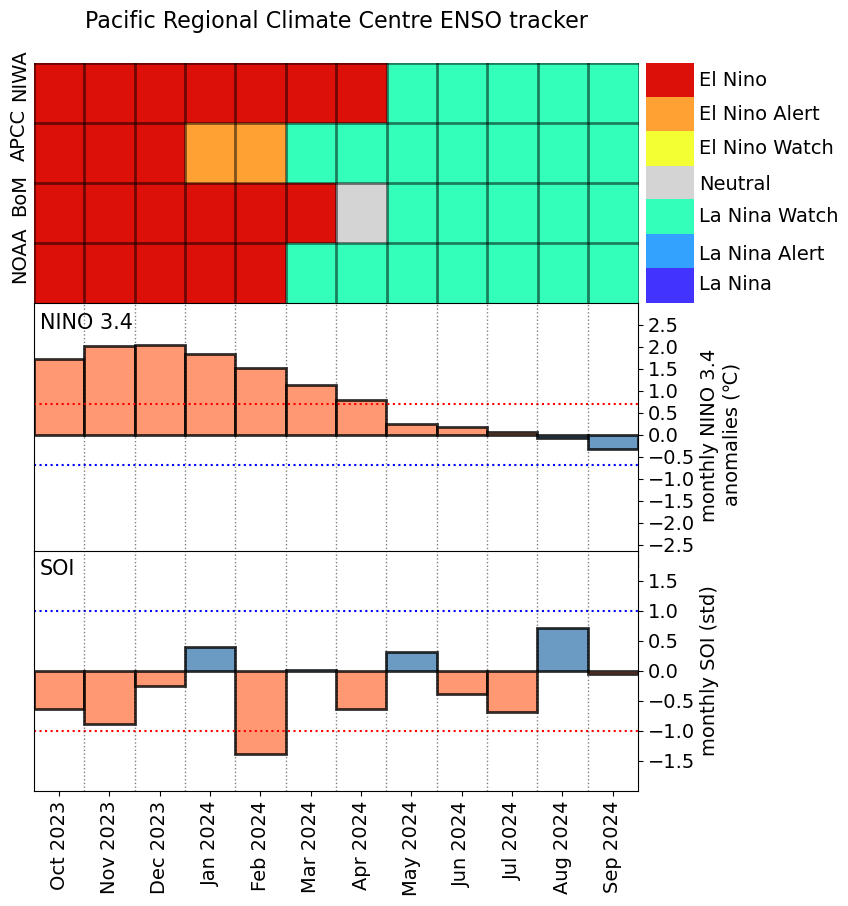

In [124]:
f = plt.figure(figsize=(8,8))

# defines the axes [left, bottom, width, height]

ax0 = f.add_axes([0.1, 0.66, 0.9, 0.3])

ax0.set_title("Pacific Regional Climate Centre ENSO tracker\n", fontsize=16)

ax1 = f.add_axes([0.1, 0.33, 0.755, 0.33])

ax2 = f.add_axes([0.1, 0.05, 0.755, 0.30])

#============================================================================================================================
# first set of axes: ENSO categories heatmap 

sns.heatmap(enso_cat_int.T, cmap=cm, center=0, vmin=-3, vmax=3, ax=ax0, \
            cbar_kws={'aspect':5, 'pad':0.01}) 

colorbar = ax0.collections[0].colorbar 

ax0.set_yticks([0.8, 1.8, 2.8, 3.8]);

ax0.set_yticklabels(['NOAA','BoM','APCC','NIWA'], fontsize=14)

ax0.set_ylim(bottom=0,top=4)

[ax0.axvline(x, color='k', lw=2, alpha=0.5) for x in range(0,len(enso_cat_int) + 1)];

[ax0.axhline(x, color='k', lw=2, alpha=0.5) for x in range(1,5)];

ax0.tick_params(direction='out', length=0, width=0)

colorbar.set_ticks([-2.5, -1.75, -0.8,  0.,  0.90, 1.75,  2.6])

colorbar.set_ticklabels(["La Nina", "La Nina Alert", "La Nina Watch", "Neutral", "El Nino Watch", "El Nino Alert", "El Nino"])    

colorbar.ax.tick_params(direction='out', length=0, width=0)

#============================================================================================================================
# second set of axes: ENSO barplot

ax1.bar(basis[nino_values>=0],nino_values[nino_values>=0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)
ax1.bar(basis[nino_values<0],nino_values[nino_values<0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)

ax1.set_xticks(basis)

ax1.set_xticklabels(dates_str, rotation=90)

ax1.set_xlim([-0.5,len(dates) - 0.5])

# get the minimum and maximum values, and set limits and ticks for the y-axis accordingly 
max_nino = np.ceil(np.max(np.abs(nino_values)))
min_nino =- max_nino

if max_nino > 1: 
    ax1.set_ylim([min_nino, max_nino])
    ax1.set_yticks(np.arange(min_nino+0.5, max_nino, 0.5))
else: 
    ax1.set_ylim([-1, 1])
    ax1.set_yticks([-0.7, 0, 0.7])                  
    
ax1.axhline(-0.7, ls=':', color='b')
ax1.axhline(0.7, ls=':', color='r')

ax1.yaxis.tick_right()

ax1.set_ylabel('monthly NINO 3.4\nanomalies (℃)', fontsize=14)

ax1.yaxis.set_label_position("right")

[ax1.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

ax1.set_xlabel('month', fontsize=14)

ax1.text(0.01, 0.9, 'NINO 3.4', transform=ax1.transAxes, fontsize=15)

#============================================================================================================================
# second set of axes: SOI barplot

ax2.bar(basis[soi_values>=0],soi_values[soi_values>=0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)
ax2.bar(basis[soi_values<0],soi_values[soi_values<0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)

ax2.set_xticks(basis)

ax2.set_xticklabels(dates_str, rotation=90)

ax2.set_xlim([-0.5,len(dates) - 0.5])

# get the minimum and maximum values, and set limits and ticks for the y-axis accordingly 
max_soi = np.ceil(np.max(np.abs(soi_values)))
min_soi =- max_soi

if max_soi > 1.5: 
    ax2.set_ylim([min_soi, max_soi])
    ax2.set_yticks(np.arange(min_soi+0.5, max_soi, 0.5))
else: 
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_yticks([-1, 0, 1])       

ax2.axhline(-1, ls=':', color='r')
ax2.axhline(1, ls=':', color='b')

ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

ax2.set_ylabel('monthly SOI (std)', fontsize=14)

ax2.yaxis.set_label_position("right")

ax2.text(0.01, 0.9, 'SOI', transform=ax2.transAxes, fontsize=15)

[ax2.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

# f.patch.set_facecolor('0.99')
f.patch.set_facecolor('w')

### saves to file 

In [125]:
f.savefig('../figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')

### push to github

In [127]:
%cd "/Users/ben.noll/weather/Pacific_RCC/notebooks/figures"

# Commit and push changes to a Git repository from Jupyter Notebook

# Specify the Git commands as strings
git_add = 'git add -A'
git_commit = 'git commit -m "monthly update"'
git_push = 'git push'

# Execute Git commands using the ! prefix
!{git_add}
!{git_commit}
!{git_push}

/Users/ben.noll/weather/Pacific_RCC/notebooks/figures
[master 4310eba] monthly update
 Committer: BenNollWeather <ben.noll@niwa-1024096.niwa.local>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 4 files changed, 4988 insertions(+), 172 deletions(-)
 create mode 100644 notebooks/.ipynb_checkpoints/Pacific_RCC_ENSO_tracker_v4-checkpoint.ipynb
 create mode 100644 notebooks/Pacific_RCC_ENSO_tracker_v4.ipynb
Enumerating objects: 15, done.
Counting objects: 100% (15/15), done.
Delta compression using up to 14 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 274.77 KiB | 16.16 MiB/s, done.
Total 9 (delta 4), reused 0 (d